<a href="https://colab.research.google.com/github/PedroAdair/News_country/blob/main/News_detect_country.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identificar el pais de origen de noticias.
### Pedro Adair Gallegos Avila

En el presente có

##Instalación de librerias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#title Instalamos transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.3 MB/s 
     |████████████████████████████████| 182 kB 50.0 MB/s 
     |████████████████████████████████| 7.6 MB 14.5 MB/s 


##Librerias

In [ ]:
#@title Librerias generales
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
#@title Especificaciones de RAM
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


##Lectura y preprocesamiento

In [ ]:
#@title get_texts_from_dir()
def get_texts_from_dir(cat_dir):
  texts = []
  data_dir = cat_dir
  category_index = {}
  categories = []
  for category_name in sorted(os.listdir(data_dir)):
    category_id = len(category_index)
    category_index[category_name] = category_id
    category_path = os.path.join(data_dir, category_name)
    for f_name in sorted(os.listdir(category_path)):
      f_path = os.path.join(category_path, f_name)
      f = open(f_path, "r", encoding="utf8")
      texts += [f.read()]
      f.close()
      categories += [category_id]
  print("%d files loaded from %s" % (len(texts), cat_dir))
  return texts, categories, category_index

In [ ]:
#@title Funciones NLTK
"""
NLKT es la opción que selecciones para preprocesar mis textos
"""
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

#Para stop words en español
es_stop = set(nltk.corpus.stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#@title Carga de noticias
# Load the RAW text and Category labels D:/posgrado/tercer_semestre/CienciaDatos/Tarea2/hispablogs/hispablogs/test

tr_txt, tr_y, tr_y_ind = get_texts_from_dir("/content/drive/MyDrive/Tarea4_TSCD/hispablogs/train")
te_txt, te_y, te_y_ind = get_texts_from_dir("/content/drive/MyDrive/Tarea4_TSCD/hispablogs/test")

2250 files loaded from /content/drive/MyDrive/Tarea4_TSCD/hispablogs/train
1000 files loaded from /content/drive/MyDrive/Tarea4_TSCD/hispablogs/test


Preprocesamiento

In [ ]:
#@title  preprocess_text()

stemmer = WordNetLemmatizer()
word_punctuation_tokenizer = nltk.WordPunctTokenizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))
        document =re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',document)
        document = re.sub(r'[àáâãäå]', 'a',document)
        document = re.sub(r'[èéêë]', 'e', document)
        document = re.sub(r'[ìíîï]', 'i', document)
        document = re.sub(r'[òóôõö]', 'o', document)
        document = re.sub(r'[ùúûü]', 'u', document)
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in es_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [ ]:
#@title Noticias preprocesadas
#preproceso todos los documentos par evitar embeddings de palabras no importantes
final_corpus_train = [preprocess_text(document) for document in tr_txt if document.strip() !='']
final_corpus_test = [preprocess_text(document) for document in te_txt if document.strip() !='']

In [ ]:
df = pd.DataFrame(list(zip(final_corpus_train, tr_y)))

In [ ]:
batch_1 = df#[:2000]
batch_1.sample(5)

,0,1
76,complicado llegar casa noche despues largo lab...,0
2216,visperas ii_guerra_mundial yorkshire reino_uni...,4
2198,cancion refleja piensa recuerden forma pensar ...,4
1020,ha_llegado segunda entrega entradas invitadas ...,2
1142,presion autonomias obliga wert revisar becasel...,2


In [ ]:
batch_1[1].value_counts()

0    450
1    450
2    450
3    450
4    450
Name: 1, dtype: int64

#Ejercicio 2

##Carga del modelo pre-entrenado

Para este trabajo, me basare unicamente en Distil BETO

In [ ]:
model_class = ppb.DistilBertModel
tokenizer_class = ppb.DistilBertTokenizer
pretrained_weights = 'dccuchile/bert-base-spanish-wwm-uncased'

In [ ]:
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing DistilBertModel: ['bert.encoder.layer.2.output.dense.weight', 'bert.encoder.layer.11.output.dense.bias', 'bert.encoder.layer.2.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.8.output.dense.weight', 'bert.encoder.layer.4.intermediate.dense.bias', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.4.attention.output.LayerNorm.bias', 'bert.encoder.layer.7.attention.output.dense.weight', 'bert.encoder.layer.11.attention.self.key.weight', 'cls.predictions.decoder.bias', 'bert.encoder.layer.4.output.dense.bias', 'bert.encoder.layer.6.output.dense.bias', 'bert.encoder.layer.1.intermediate.dense.weight', 'cls.predictions.decoder.weight', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.2.attention.output.dense.bias', 'bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight',

Tomaremos una longitud máxima de 100 palabras

In [ ]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True,truncation=True,max_length =100)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(2250, 100)

Creamos la mascara de atención

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2250, 100)

Ahora aplicamos el modelo BERT

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)


Guardo la primer capa (la del token CLS)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
features.shape

(2250, 768)

Para evitar volver a cargar el modelo cada vez, guardare estos valores en un csv

In [ ]:
features_df = pd.DataFrame(features)
features_df.to_csv('  .csv')

In [ ]:
labels = batch_1[1]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

##Representaciones en baja dimensión

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tarea4_TSCD/BERT/100features_bert.csv',index_col=0)

###Representación PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)
datared=pca.transform(df)

import plotly.express as px
fig = px.scatter(datared, x=0, y=1, color=tr_y)
fig.show()

###Representación kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=2, kernel="rbf", gamma=20, fit_inverse_transform=True, alpha=0.1)
transformer.fit(df)
datared = transformer.transform(df)

import plotly.express as px
fig = px.scatter(datared, x=0, y=1, color=tr_y)
fig.show()

###RepresentaciónMDS

In [ ]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
datared = embedding.fit_transform(df)

import plotly.express as px
fig = px.scatter(datared, x=0, y=1, color=tr_y)
fig.show()

###Representación $t$-SNE

In [ ]:
from sklearn.manifold import TSNE
datared = TSNE( n_components=2, n_iter=1000, n_iter_without_progress=150, n_jobs=-1,
               random_state=0).fit_transform(df)
import plotly.express as px
fig = px.scatter(datared, x=0, y=1, color=tr_y)
fig.show()

###Representación Isomap

In [ ]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
datared = embedding.fit_transform(features)

import plotly.express as px
fig = px.scatter(datared, x=0, y=1, color=tr_y)
fig.show()

##Ajuste de Clasificadores

A continuación realizo la clasificación de noticias basados en
* SVC:
  * lineal
  * rbf
* RFC:


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns
import scikitplot as skplt


train_features, test_features, train_labels, test_labels = train_test_split(df, tr_y)


In [ ]:
#@title PlotGraphics()
import scikitplot as skplt
target_classes = ['ar', 'cl', 'es', 'mx', 'pe']
def PlotGraphics(Y_actual, Y_preds):
  print("Test Accuracy : {:.2f}".format(accuracy_score(Y_actual, Y_preds)))
  print("F1 Score : {:.2f}".format(f1_score(Y_actual, Y_preds, average='weighted')))
  print("\nConfusion Matrix : ")
  skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
  plt.xticks(rotation=90);

###SVC Lineal

Test Accuracy : 0.25
F1 Score : 0.25

Confusion Matrix : 


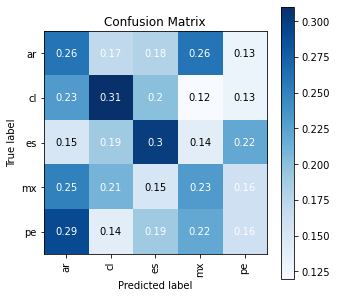

In [ ]:
svc_lineal = SVC(kernel='linear')
svc_lineal.fit(train_features, train_labels)

y_pred_scv_lineal = svc_lineal.predict(test_features)

#Se visualiza la matriz de confusión
PlotGraphics(test_labels, y_pred_scv_lineal)

###RFC

Test Accuracy : 0.20
F1 Score : 0.15

Confusion Matrix : 


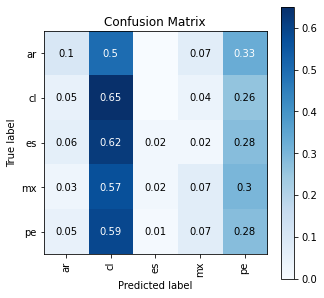

In [ ]:
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(train_features, train_labels)

y_pred_rfc = rfc.predict(test_features)

#Se visualiza la matriz de confusión
PlotGraphics(test_labels, y_pred_rfc)

#BERT

modelos   de   clasificación  usando  BERT  con  fine-tunning

In [ ]:
#final_corpus_train  tr_y  final_corpus_test te_y

In [ ]:
from sklearn.model_selection import train_test_split
X= final_corpus_train
y = tr_y

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2020)



In [ ]:
test_data = df = pd.DataFrame(list(zip(final_corpus_test,te_y)))
test_data.columns =['Noticia', 'Pais']
test_data = test_data[['Noticia', 'Pais'] ]
test_data.sample(5)

,Noticia,Pais
150,ayer descubri golf centro principiantes ciudad...,0
92,venite sabado abril horas teatro auditorium pr...,0
809,reconocimiento qhapac patrimonio humanidad par...,4
103,regalo podes perder radio rock nacional espera...,0
50,ahora les_traemos video portadas periodicos im...,0


Se realiza un preprocesamiento extra

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&' with '&'
    text = re.sub(r'&', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            truncation=True,
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Ejemplo de las mascaras de atención

In [ ]:

sequence_a = "Ayer fue un dia soleado."
sequence_b = "En las mañananas me gusta comer pan tostado, en las tardes comer manzanas y cenar cereal"

encoded_sequence_a = tokenizer(sequence_a)["input_ids"]
encoded_sequence_b = tokenizer(sequence_b)["input_ids"]

print('lengths of sequences:',len(encoded_sequence_a), len(encoded_sequence_b))
padded_sequences = tokenizer([sequence_a, sequence_b], padding=True)
print('Tokenized sequences after padding:\n', padded_sequences["input_ids"])
print('Attention mask:\n', padded_sequences["attention_mask"])

lengths of sequences: 9 21
Tokenized sequences after padding:
 [[4, 5023, 1247, 1044, 7085, 7695, 1082, 1008, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [4, 1035, 1085, 2243, 2843, 1094, 2331, 1987, 2463, 7783, 1473, 1019, 1035, 1085, 10095, 1987, 16458, 1040, 7320, 26688, 5]]
Attention mask:
 [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([X, test_data.Noticia.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True,truncation=True,max_length =100) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  100


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 100

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  brother where thou significo exito basado lejanamente odisea homero historia transcurre mississippi decada sigue tres convictos acaban escapar prision objetivo recuperar botin atraco banco lider enterrado pelicula resalta habilidades comicas george_clooney ulysses everett carta kretina furiosos fanaticos defensores modelo cubano venezolano quiero modelo propio argentina igual trato evadirme realidad cada_vez hago compras lleva desesperarme inflacion impresionante entiendo hace familia hijos mantenerse tendran tarjetas credito sueldos seran alto aquellos disculpen reflexion discriminativa genero creo mayores contaminantes planeta mujeres primero primeras consumidoras comodidad hacen usar hijos pañales descartables años comienzan jardin preescolar recien enseñan controlen necesidades franjas pobreza mujeres absorbentes sanitarios gatos diatomita tierra diatomeas tambien conocida diahydro kieselguhr kieselgur celite roca sedimentaria silicea formada micro fosiles diatomeas alga

Data Loader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

BETO model
**Nota** Aquí cambie algunas cosas

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=True):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 58.5 ms, sys: 1 ms, total: 59.5 ms
Wall time: 64.9 ms


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4, freeze_bert=True):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dens

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.591547   |     -      |     -     |  331.68  
   1    |   40    |   1.335213   |     -      |     -     |  316.70  
   1    |   60    |   1.277693   |     -      |     -     |  319.94  
   1    |   80    |   1.283748   |     -      |     -     |  333.66  
   1    |   100   |   1.166422   |     -      |     -     |  331.91  
   1    |   120   |   1.260498   |     -      |     -     |  329.48  
   1    |   126   |   1.196468   |     -      |     -     |   94.70  
----------------------------------------------------------------------
   1    |    -    |   1.315534   |  0.959711  |   66.25   |  2125.85 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------------

In [ ]:
print(bert_classifier.Linear(x).size())

AttributeError: ignored